In [1]:
import tensorflow as tf

import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)

Using TensorFlow backend.


1.12.0


In [2]:
cabspotting = pd.read_pickle('../cabspotting/' + 'cabspotting.pkl')
cabspotting.head()

latitude  longitude  occupied
taxi   time                                              
abboip 2008-05-17 14:12:10  37.75153 -122.39447         0
       2008-05-17 14:13:34  37.75149 -122.39447         0
       2008-05-17 14:14:34  37.75149 -122.39447         0
       2008-05-17 14:15:35  37.75149 -122.39446         0
       2008-05-17 14:41:43  37.75144 -122.39449         0

In [3]:
cabspotting.reset_index(inplace=True)
cabspotting.head()

,taxi,time,latitude,longitude,occupied
0,abboip,2008-05-17 14:12:10,37.75153,-122.39447,0
1,abboip,2008-05-17 14:13:34,37.75149,-122.39447,0
2,abboip,2008-05-17 14:14:34,37.75149,-122.39447,0
3,abboip,2008-05-17 14:15:35,37.75149,-122.39446,0
4,abboip,2008-05-17 14:41:43,37.75144,-122.39449,0


In [4]:
# Some statistics on the lengths of the mov data per taxi
cabspotting.groupby('taxi').size().describe()

count      536.000000
mean     20932.751866
std       6204.004840
min         59.000000
25%      18721.250000
50%      22813.500000
75%      25037.750000
max      49367.000000
dtype: float64

In [5]:
import datetime as dt

cabspotting['rebased_time'] = cabspotting['time'] - cabspotting['time'].min()
cabspotting['rebased_time'] = cabspotting['rebased_time'].dt.total_seconds()
cabspotting.head()

,taxi,time,latitude,longitude,occupied,rebased_time
0,abboip,2008-05-17 14:12:10,37.75153,-122.39447,0,15126.0
1,abboip,2008-05-17 14:13:34,37.75149,-122.39447,0,15210.0
2,abboip,2008-05-17 14:14:34,37.75149,-122.39447,0,15270.0
3,abboip,2008-05-17 14:15:35,37.75149,-122.39446,0,15331.0
4,abboip,2008-05-17 14:41:43,37.75144,-122.39449,0,16899.0


In [6]:
cabspotting.drop(['time', 'occupied'], axis=1, inplace=True)
cabspotting.head()

,taxi,latitude,longitude,rebased_time
0,abboip,37.75153,-122.39447,15126.0
1,abboip,37.75149,-122.39447,15210.0
2,abboip,37.75149,-122.39447,15270.0
3,abboip,37.75149,-122.39446,15331.0
4,abboip,37.75144,-122.39449,16899.0


In [7]:
def extract_sequence(df):
    df.drop('taxi', axis=1, inplace=True)
    df.sort_values(by='rebased_time', inplace=True)
    return df.values

cabspotting = cabspotting.groupby('taxi').apply(extract_sequence)
cabspotting.head()

taxi
abboip      [[37.751529999999995, -122.39447, 15126.000000...
abcoij      [[37.80346, -122.41466000000001, 47486.0], [37...
abdremlu    [[37.75521, -122.39093000000001, 11949.0], [37...
abgibo      [[37.7733, -122.4374, 16.0], [37.77791, -122.4...
abjoolaw    [[37.75159, -122.39747, 13856.0], [37.74949, -...
dtype: object

In [8]:
cabspotting['abboip']

array([[ 3.7751530e+01, -1.2239447e+02,  1.5126000e+04],
       [ 3.7751490e+01, -1.2239447e+02,  1.5210000e+04],
       [ 3.7751490e+01, -1.2239447e+02,  1.5270000e+04],
       ...,
       [ 3.7751990e+01, -1.2239460e+02,  2.0661360e+06],
       [ 3.7751360e+01, -1.2239527e+02,  2.0662550e+06],
       [ 3.7751340e+01, -1.2239488e+02,  2.0662830e+06]])

In [9]:
cabspotting.shape

(536,)

In [10]:
def to_single_sequence(series):
    data = None
    for _, item in series.iteritems():
        if data is None:
            data = item
        else:
            data = np.concatenate((data, item), axis=0)
    
    return data

data = to_single_sequence(cabspotting)

data.shape

(11219955, 3)

/Users/jankaiser/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


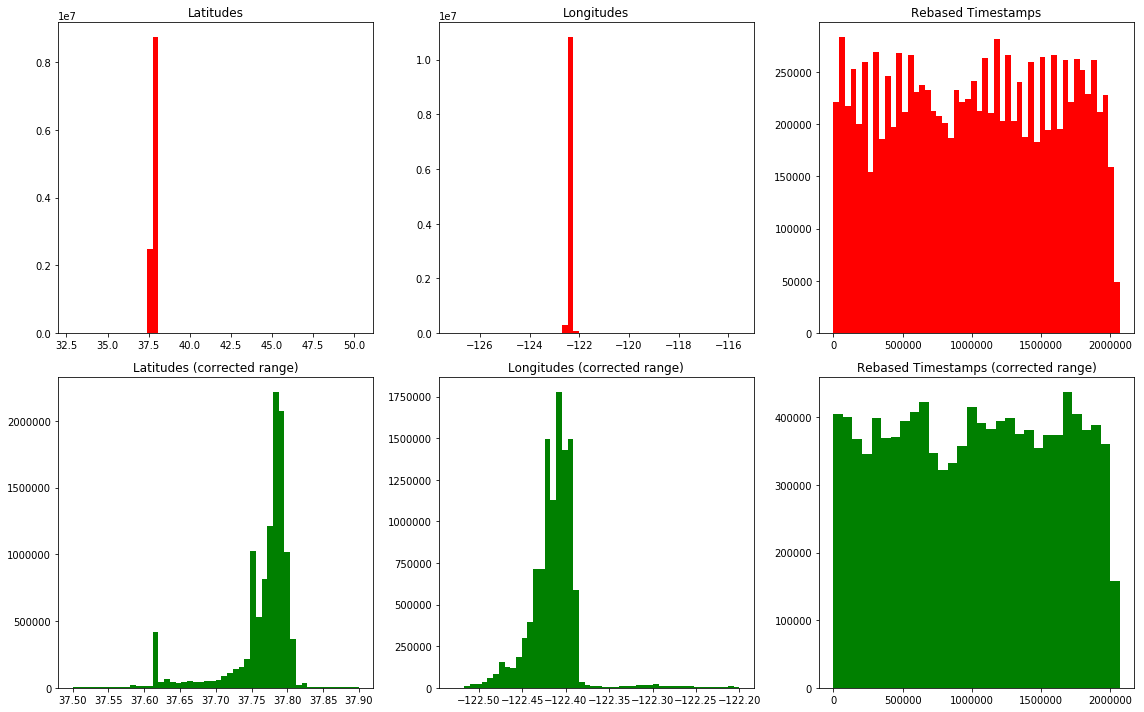

In [11]:
fig, ((a0, a1, a2), (a0c, a1c, a2c)) = plt.subplots(2, 3, figsize=(16, 10))

a0.hist(data[:,0], bins=50, color='red')
a0.set_title('Latitudes')

a1.hist(data[:,1], bins=50, color='red')
a1.set_title('Longitudes')

a2.hist(data[:,2], bins=50, color='red')
a2.set_title('Rebased Timestamps')

a0c.hist(data[:,0], bins=50, range=(37.5, 37.9), color='green')
a0c.set_title('Latitudes (corrected range)')

a1c.hist(data[:,1], bins=50, range=(-122.53, -122.2), color='green')
a1c.set_title('Longitudes (corrected range)')

a2c.hist(data[:,2], bins=30, color='green')
a2c.set_title('Rebased Timestamps (corrected range)')

fig.tight_layout()
fig.show()

In [12]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
scaler.fit(data)

print('Means: %f %f %f' % (scaler.mean_[0], scaler.mean_[1], scaler.mean_[2]))
print('Standard deviations: %f %f %f' % (scaler.var_[0], scaler.var_[1], scaler.var_[2]))

Means: 37.763601 -122.412432 1017983.546543
Standard deviations: 0.002901 0.001280 346406383099.499146


In [13]:
print('Before:')
print(data)   # Before
print()
data = scaler.transform(data)
print('After:')
print(data)   # After

Before:
[[ 3.7751530e+01 -1.2239447e+02  1.5126000e+04]
 [ 3.7751490e+01 -1.2239447e+02  1.5210000e+04]
 [ 3.7751490e+01 -1.2239447e+02  1.5270000e+04]
 ...
 [ 3.7756860e+01 -1.2244239e+02  2.0172080e+06]
 [ 3.7760470e+01 -1.2244215e+02  2.0172640e+06]
 [ 3.7760750e+01 -1.2243687e+02  2.0173250e+06]]

After:
[[-0.22410877  0.50197561 -1.70390864]
 [-0.22485143  0.50197561 -1.70376591]
 [-0.22485143  0.50197561 -1.70366397]
 ...
 [-0.12514886 -0.83724035  1.69773582]
 [-0.05812348 -0.83053309  1.69783096]
 [-0.05292484 -0.6829734   1.69793461]]


In [14]:
TRAIN_TEST_SPLIT = 0.8
VALIDATION_PROPORTION = 0.2

n_train = int(np.floor(TRAIN_TEST_SPLIT * data.shape[0]))
n_validation = int(np.floor(VALIDATION_PROPORTION * data.shape[0]))

training_data = data[0:n_train]
validation_data = data[0:n_validation]
test_data = data[n_train:]

training_data.shape, validation_data.shape, test_data.shape

((8975964, 3), (2243991, 3), (2243991, 3))

In [15]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, sequence_length=20, batch_size=32):
        'Initialization'
        data_length = data.shape[0]
        n_batches = (data_length - 1) // (batch_size * sequence_length)
        rounded_data_length = n_batches * batch_size * sequence_length
        
        X_data = np.reshape(data[0:rounded_data_length], [batch_size, n_batches * sequence_length, 3])
        y_data = np.reshape(data[1:rounded_data_length + 1], [batch_size, n_batches * sequence_length, 3])
        
        self.n_batches = n_batches
        self.sequence_length = sequence_length
        self.X_data = X_data
        self.y_data = y_data
        
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.n_batches
    
    def __getitem__(self, index):
        'Generate one batch of data'        
        X = self.X_data[:, index * self.sequence_length:(index + 1) * self.sequence_length]
        y = self.y_data[:, index * self.sequence_length:(index + 1) * self.sequence_length]
        
        return X, y
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.X_data = np.roll(self.X_data, -1, axis=0)
        self.y_data = np.roll(self.y_data, -1, axis=0)

training_generator = DataGenerator(training_data)
validation_generator = DataGenerator(validation_data)

In [16]:
model = keras.Sequential([
    keras.layers.GRU(512, return_sequences=True, input_shape=(20, 3)),
    keras.layers.TimeDistributed(keras.layers.Dense(3, activation='relu'))
])
model.compile(loss='mean_squared_error',
              optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 20, 512)           792576    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 3)             1539      
Total params: 794,115
Trainable params: 794,115
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Callback for saving checkpoints
filepath = 'checkpoints/' + 'checkpoints/one-gru-mse-{epoch:02d}-{loss:.4f}.hdf5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1)

In [ ]:
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=20,
                    callbacks=[checkpoint],
                    use_multiprocessing=True,
                    workers=6)

Epoch 1/20
